# Housing - exploratory data analysis (EDA)

NYC housing dataset b/w in 2012-13, seperated by boroughs


##### Notes
- **raw_data** is readed file w/ proper types and formats
- **data_prepared**, dataframe after missing values (sale_price) and **obvious** rows/columns eliminated
- **data_cleaned**,  dataframe after **outliers** eliminated
- **data_enriched**, starts w/ data, + null row deletions, enrichments (_map, _log ..)  etc...

### possible deletion columns/rows

   - columns
       - borough, building_class_category .. (extracted into diff. columns)
       - block, lot (nonsense)
       - easement (%100 empty), 
       - apartment_number (%74 empty)
   - rows
       - **30% of sale_price is 0 (28K+)**
       - building_class_name is null, is **(1500)**
       - tax_class_at_present is empty, is **(270)**     
   - outliers  
       - (data_cleaned.gross_square_feet > 0) & (data_cleaned.gross_square_feet <= 20K)
       - (data_cleaned.sale_price < 2M)  


### categorical features

  - building_class_at_present: may be mapped into 3 groups to use later ?
      - if containf FAMILY, Map as FAMILY in building_class_map
  - building_class_at_present vs building_class_at_sale change has any meaning?
  - tax_class_at_present vs tax_class_at_sale has any meaning? (1, 2 and 4 is dominating values)
  - 10019 zipcode is %7 of houses, and 70K houses are located in of 100 zipcodes
  - 4000+ diff. apartment_number in 85K rows.
  - top 50 neighborhood covers 50K+ houses
  
### numerical features

  - **50% of estates has 0 land_square_feet and gross_square_feet.**
  - **how can residential_units and commercial_units be used as numeric columns in a meaningful way?**
      - residential_units (165 types), %50 is 0 and 1 (40K+ rows) and 30K+ NaN. 
      - commercial_units (23 types), 0 has 20K+, NaN is 60K+
      - total_units (171 types), 1 (25K+, 0 (16K+), 2 (8K+) and **NaN is 30K**
         - total = residental + commercial ?
         - if there are dif, can we set to commercial or we should delete  or we may use to create a dummy category ?
         - if total = 0 or null **(18K rows)** , what we should do?

- [ ] **can we predict total_units, then set null values, then make them numeric**
- [ ] **can we predict year_built, then set 0 values,


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import os
import glob

sns.set()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 250)


In [47]:
# tuning params

neighborhood_min_len = 2

sale_price_min = 1000 # minimum intuitive sales price
sale_price_lq = 0.01  # left quantile
sale_price_rq = 0.99  # right quantile

building_class_mapping = ['FAMILY', 'APARTMENT', 'FACILITIES'] # maps building_class_category

In [3]:
# read all datasets w/ dates
filenames = glob.glob(os.path.join('dataset/housing/', 'r*.csv'))

#
li = []

for filename in filenames:
    df = pd.read_csv(filename, \
                dtype={'YEAR BUILT': object, 'BLOCK': object, 'LOT': object, 'ZIP CODE': object, 
                       'COMMERCIAL UNITS': object,
                       'BOROUGH': object, 'NEIGHBORHOOD': object, 'BUILDING CLASS CATEGORY': object,
                       'TAX CLASS AT PRESENT': object,  'EASE-MENT': object,
                       'BUILDING CLASS AT PRESENT': object, 'ADDRESS': object, 
                       'APART\nMENT\nNUMBER': object,
                       'RESIDENTIAL UNITS': object, 'COMMERCIAL UNITS': object, 'TOTAL UNITS': object,
                       'LAND SQUARE FEET': object, 'GROSS SQUARE FEET': object,
                       'TAX CLASS AT TIME OF SALE': object, 'BUILDING CLASS AT TIME OF SALE': object,
                       'SALE\nPRICE': str}, \
                parse_dates=['SALE DATE'], \
                infer_datetime_format=True)
    li.append(df)


raw_data = pd.concat(li, axis=0, ignore_index=True)

# change column names
raw_data.columns = ['borough', 'neighborhood', 'building_class_category',
                    'tax_class_at_present', 'block', 'lot', 'easement',
                    'building_class_at_present', 'address', 'apartment_number',
                    'zipcode', 'residential_units', 'commercial_units', 'total_units',
                    'land_square_feet', 'gross_square_feet', 'year_built',
                    'tax_class_at_sale', 'building_class_at_sale',
                    'sale_price', 'sale_date']

raw_data.head(2)

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date
0,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1103,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$403,572",2013-07-09
1,3,,15 CONDOS - 2-10 UNIT RESIDENTIAL,,814,1105,,,342 53RD STREET,,11220,0,0,0,0,0,0,2,R1,"$218,010",2013-07-12


# Explore

- map and extract some of them, 
- delete white-spaces, 
- delete comma and $
- convert some object columns to number !
- check outliers
- reduced categorigal features into less
- delete rows and columns

### quick checks

In [4]:
raw_data.isnull().sum()

# no null, but empty values filled w/ blanks! so it requires more operations !

borough                      0
neighborhood                 0
building_class_category      0
tax_class_at_present         0
block                        0
lot                          0
easement                     0
building_class_at_present    0
address                      0
apartment_number             0
zipcode                      0
residential_units            0
commercial_units             0
total_units                  0
land_square_feet             0
gross_square_feet            0
year_built                   0
tax_class_at_sale            0
building_class_at_sale       0
sale_price                   0
sale_date                    0
dtype: int64

### mappings for categorical features

In [5]:
data = raw_data

In [6]:
data['borough_name'] = data['borough'].map({'1':'Manhattan', '3':'Brooklyn', 
                                                    '2':'Bronx', '4':'Queens', 
                                                    '5':'Staten Island'})   

data.borough_name.head(1)

0    Brooklyn
Name: borough_name, dtype: object

In [7]:
data.drop('borough', axis=1, inplace=True)

data.columns

Index(['neighborhood', 'building_class_category', 'tax_class_at_present',
       'block', 'lot', 'easement', 'building_class_at_present', 'address',
       'apartment_number', 'zipcode', 'residential_units', 'commercial_units',
       'total_units', 'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_sale', 'building_class_at_sale', 'sale_price',
       'sale_date', 'borough_name'],
      dtype='object')

### cleansing

- look via a text editor to see obvious issues
- start w/ dependent & numerical features

##### sale_price

In [8]:
x = data

In [9]:
# delete $ and , chars
# sale_price is object, but it has to be numeric !
x.groupby(x.sale_price).size().head(3)

sale_price
$0       26959
$0.00     1679
$1         147
dtype: int64

In [10]:
x['sale_price'] = x['sale_price'].str.replace(r',|\$', '').astype(float)

In [11]:
x.sale_price.describe()

# mean 885K, median 226K  -> skewed
# 50% quantile == 0.. delete'em all   ~28K
# 75% quantile and max value is enormuous . outliers

count    8.597500e+04
mean     8.850979e+05
std      9.424213e+06
min      0.000000e+00
25%      0.000000e+00
50%      2.600000e+05
75%      6.200000e+05
max      1.307965e+09
Name: sale_price, dtype: float64

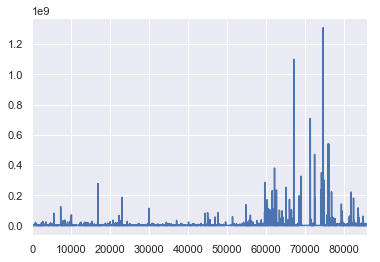

In [12]:
# x axis contains index number :)
# seems outliers

x.sale_price.plot()

In [13]:
x = x[x.sale_price > sale_price_min]

len(data), len(x)

(85975, 55900)

In [14]:
x.sale_price.describe()

# mean 1.3M, median 491K, still skewed
# min 1100, 25% 277K -> outliers from left
# 75% 850K, max 1.3b -> outliers from right

count    5.590000e+04
mean     1.361290e+06
std      1.165987e+07
min      1.100000e+03
25%      2.773358e+05
50%      4.910000e+05
75%      8.500000e+05
max      1.307965e+09
Name: sale_price, dtype: float64

In [15]:
# we can take b/w those values

q1 = x.sale_price.quantile(sale_price_lq)

q2 = x.sale_price.quantile(sale_price_rq)

q1, q2

(15000.0, 12150000.0)

(54767, <matplotlib.axes._subplots.AxesSubplot at 0x1a19f8e2e8>)

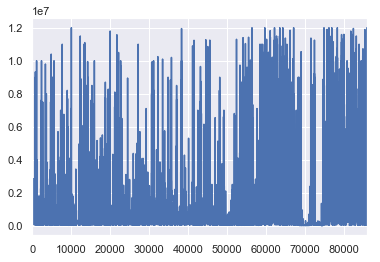

In [16]:
x = x[(x.sale_price > q1) & (x.sale_price < q2)]

len(x), x.sale_price.plot()

# seems much better
# still tuning opportunity, can be controlled by tuning params !

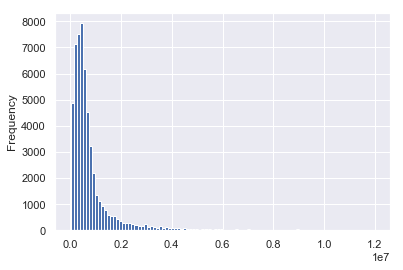

In [17]:
x.sale_price.plot.hist(bins=100)

In [18]:
data = x

##### neighborhood

In [19]:
x = data

In [20]:
# below means there are whitespaces or check inside a text editor

x[x.neighborhood == 'ANNADALE'].head()

,neighborhood,building_class_category,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date,borough_name


In [21]:
# if whitespaces at the begining, groupby is good. but not enough
# good for double checks 
# delete empty values 25/85K

data.groupby('neighborhood').size().head(5)

neighborhood
                              23
AIRPORT LA GUARDIA             3
ALPHABET CITY                111
ANNADALE                      99
ARDEN HEIGHTS                171
dtype: int64

In [22]:

x['neighborhood'] = x.loc[:, 'neighborhood'].str.split(r'(\s+)$', expand=True)[0]

In [23]:
x.groupby('neighborhood').size().head(3)

neighborhood
                       23
AIRPORT LA GUARDIA      3
ALPHABET CITY         111
dtype: int64

In [24]:
x[x.neighborhood == 'ANNADALE'].head(3)

# means whitespaces cleaned

,neighborhood,building_class_category,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date,borough_name
23373,ANNADALE,01 ONE FAMILY HOMES,1,5395,32,,A1,541 SYCAMORE STREET,,10312,1,0,1,"13,320","4,696",1985,1,A1,1200000.0,2012-08-15,Staten Island
23374,ANNADALE,01 ONE FAMILY HOMES,1,5401,10,,A2,16 JANSEN STREET,,10312,1,0,1,"10,800","2,015",1980,1,A2,705000.0,2013-02-08,Staten Island
23375,ANNADALE,01 ONE FAMILY HOMES,1,5401,38,,A1,27 WEAVER STREET,,10312,1,0,1,"10,833","2,128",1980,1,A1,127500.0,2012-09-26,Staten Island


In [25]:
# filter

x = x[x.neighborhood.str.len() > neighborhood_min_len]

In [26]:
# can we reduce into less groups ? (for dummy features)
# nope, or requires domain know-how

x.groupby('neighborhood').size().head()


neighborhood
AIRPORT LA GUARDIA      3
ALPHABET CITY         111
ANNADALE               99
ARDEN HEIGHTS         171
ARROCHAR               13
dtype: int64

In [27]:
x.neighborhood.describe()

count            54744
unique             252
top       MIDTOWN WEST
freq              2866
Name: neighborhood, dtype: object

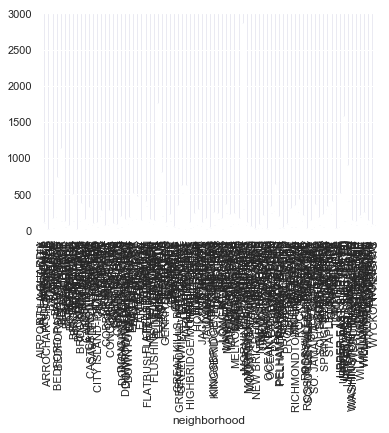

In [28]:
x.groupby('neighborhood').size().plot(kind='bar')

In [29]:
data = x

### building_class_category

- split into 2 columns (exract text)
- eliminate white spaces
- reduce into less categories (dummy variables)

In [30]:
x = data

In [31]:
# empty 1042 , delete'em all

x.groupby('building_class_category').size().head(10)

building_class_category
                                                1042
01  ONE FAMILY HOMES                            9337
02  TWO FAMILY HOMES                            7868
03  THREE FAMILY HOMES                          2121
04  TAX CLASS 1 CONDOS                           849
05  TAX CLASS 1 VACANT LAND                      415
06  TAX CLASS 1 - OTHER                           43
07  RENTALS - WALKUP APARTMENTS                 2118
08  RENTALS - ELEVATOR APARTMENTS                267
09  COOPS - WALKUP APARTMENTS                   2352
dtype: int64

In [32]:
x.building_class_category.describe()

count                                            54744
unique                                              38
top       10  COOPS - ELEVATOR APARTMENTS             
freq                                             12437
Name: building_class_category, dtype: object

In [33]:
kkk = pd.DataFrame(data['building_class_category'])


# (^\s)|(\s+)$
# r'(\s+)$' and r'(^\S+)(\s+)

kkk['building_class_category_'] = kkk['building_class_category'].str.split(r'(\s+)$', expand=True)[0].str.split(r'(^\S+)(\s+)')
# kkk['_len'] = kkk['building_class_category'].str.len()
# kkk['__len'] = kkk['building_class_category'].str.len()
# kkk['__diff'] = kkk._len - kkk.__len


kkk.head(10)
# kkk[kkk.__diff > 0 ]
# kkk[kkk.total_units == '']

,building_class_category,building_class_category_
25,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
26,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
27,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
28,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
30,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
31,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
32,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
33,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
34,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"
36,01 ONE FAMILY HOMES,"[, 01, , ONE FAMILY HOMES]"


In [34]:
# whitespace at end
# then, extract 01 and CONDOS - xyz part
# 01 CONDOS - xyz klm   


x['building_class'] = x['building_class_category'].str.split(r'(\s+)$', expand=True)[0] \
                                                  .str.split(r'(^\S+)(\s+)', expand=True)[3]

In [35]:
# 1253 records deleted

x = x[x.building_class.notna()]

In [36]:
len(data), len(x)

(54744, 53702)

In [37]:
x.head(2)

,neighborhood,building_class_category,tax_class_at_present,block,lot,easement,building_class_at_present,address,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_sale,building_class_at_sale,sale_price,sale_date,borough_name,building_class
25,BATH BEACH,01 ONE FAMILY HOMES,1,6363,23,,A9,8641 16TH AVENUE,,11214,1,0,1,"2,058","1,492",1930,1,A9,560000.0,2013-06-06,Brooklyn,ONE FAMILY HOMES
26,BATH BEACH,01 ONE FAMILY HOMES,1,6366,69,,A1,8658 BAY 16TH STREET,,11214,1,0,1,"4,833","1,724",1930,1,A1,860000.0,2012-12-18,Brooklyn,ONE FAMILY HOMES


In [38]:
# eliminate after extraction
x.drop(['building_class_category'], axis=1, inplace=True)

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [39]:
x.columns

Index(['neighborhood', 'tax_class_at_present', 'block', 'lot', 'easement',
       'building_class_at_present', 'address', 'apartment_number', 'zipcode',
       'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_sale', 'building_class_at_sale', 'sale_price',
       'sale_date', 'borough_name', 'building_class'],
      dtype='object')

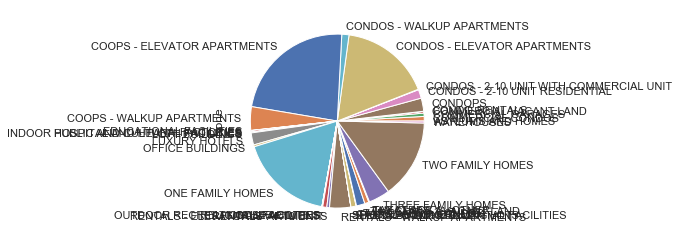

In [42]:
x.groupby('building_class').size().plot(kind='pie')

In [45]:
# enrich

y = x


for m in building_class_mapping:
    y.loc[y.building_class.str.contains(m), 'building_class_map'] = m


# this keeps getting decreased, above lines increased
y.loc[y.building_class_map.isna(), 'building_class_map'] = 'OTHER'

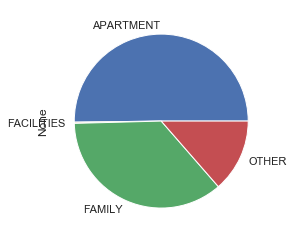

In [50]:

y.groupby('building_class_map').size().plot(kind='pie')

# len(data_enriched[data_enriched.building_class_map.notna()])
# 20K records contains family, 15K+ apartment

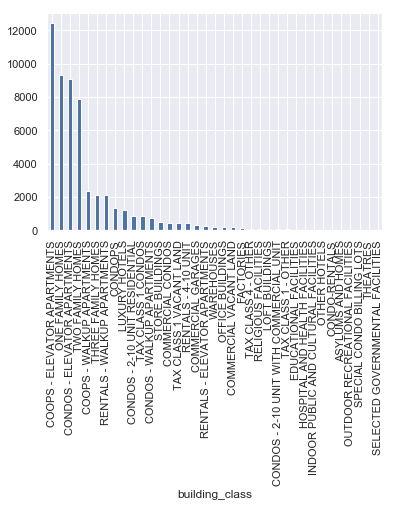

In [58]:
y.groupby('building_class').size().sort_values(ascending=False).plot(kind='bar')

In [61]:
len(data), len(x)

(53702, 53702)

In [59]:
data = y

In [60]:
len(data)

53702

### tax_class_at_present, tax_class_at_sale

In [ ]:
data_prepared = data_prepared[data_prepared.tax_class_at_present != '  '] #271 rows

### block, lot, easement

In [ ]:
raw_data.groupby('easement').size()

# can be deleted

In [ ]:
raw_data.groupby('block').size().plot()

# it reads as numerical, but infact categorical
# can be deleted

In [ ]:
raw_data.groupby('lot').size().plot()

# it reads as numerical, but infact categorical
# can be deleted

### building_class_at_present, building_class_at_sale

In [ ]:
raw_data.groupby('building_class_at_sale').size().sort_values(ascending=False).plot()

### address, apartment_number, zipcode

In [ ]:
kkk = pd.DataFrame(raw_data['apartment_number'])

kkk.groupby('apartment_number').size().sort_index().head(10)

# 60K+ empty
# nothing special
# remove column

In [ ]:
kkk = pd.DataFrame(raw_data['address'])


# (^\s)|(\s+)$

kkk['address_'] = kkk['address'].str.split(r'(^\s)|(\s+)$', expand=True)[3]
kkk['address_len'] = kkk['address'].str.len()
kkk['address__len'] = kkk['address_'].str.len()
kkk['address__diff'] = kkk.address_len - kkk.address__len


kkk.head()

In [ ]:
    
#  white-spaces at the beginning, white-spaces at the end cleared
#  b/w words, white-space remains 
raw_data['address_'] = raw_data['address'].str.split(r'(^\s+)|(\s+)$', expand=True)[3]

### residential_units, commercial_units, total_units

In [ ]:
raw_data[['residential_units', 'commercial_units', 'total_units']].head(20)

# total = residental + commercial ?
# if there are dif, can we set to commercial or we should delete  or we may use to create a dummy category ?
# if total = 0 , what we should do?

In [ ]:
raw_data['residential_units'] = raw_data['residential_units'].str.replace(r',', '')
raw_data['commercial_units'] = raw_data['commercial_units'].str.replace(r',', '')
raw_data['total_units'] = raw_data['total_units'].str.replace(r',', '')

In [276]:
len(kkk[kkk.total_units.isna()])

len(kkk[kkk.residential_units.isna()])

kkk.groupby('total_units').size().sort_values(ascending=False).head(10)#.plot()

kkk.groupby('commercial_units').size().sort_values(ascending=False).head(10)#.plot()

total_units
1     25991
0     16133
2      8178
3      2289
4       612
6       450
5       323
10      192
8       182
7       166
dtype: int64

In [292]:
# we can set empty residential_units w/ means by building_class_name,
# or we can cluster then, predict more meaningful values?

xyz = raw_data[raw_data.residential_units.isna()]

xyz.groupby('building_class_name').size()

building_class_name
ASYLUMS AND HOMES                             7
COMMERCIAL CONDOS                           488
COMMERCIAL GARAGES                          376
COMMERCIAL VACANT LAND                      206
CONDO-RENTALS                                 3
CONDOPS                                      94
CONDOS - 2-10 UNIT RESIDENTIAL              675
CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT      28
CONDOS - ELEVATOR APARTMENTS               2870
CONDOS - WALKUP APARTMENTS                  532
COOPS - ELEVATOR APARTMENTS                2172
COOPS - WALKUP APARTMENTS                   706
EDUCATIONAL FACILITIES                       30
FACTORIES                                   173
HOSPITAL AND HEALTH FACILITIES               11
INDOOR PUBLIC AND CULTURAL FACILITIES        11
LOFT BUILDINGS                               12
LUXURY HOTELS                                 2
OFFICE BUILDINGS                            170
ONE FAMILY HOMES                           6383
OTHER HOTELS        

In [344]:
xyz_notna = raw_data[raw_data.residential_units.notna()]
xyz_notna['residential_units_'] = xyz_notna['residential_units'].astype(int)

# xyz_notna = xyz_notna.groupby(['building_class_name']).mean().round()


xyz_notna = xyz_notna.groupby(['building_class_name', 'residential_units']).size()

xyz_notna.head(5)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


building_class_name  residential_units
ASYLUMS AND HOMES    0                       3
                     2                       1
                     40                      1
                     65                      1
COMMERCIAL CONDOS    0                    1194
dtype: int64

In [426]:
raw_data.dtypes

borough                              object
borough_name                         object
neighborhood                         object
building_class_category              object
building_class                       object
building_class_name                  object
tax_class_at_present                 object
tax_class_at_sale                    object
block                                object
lot                                  object
easement                             object
building_class_at_present            object
building_class_at_sale               object
address                              object
address_                             object
apartment_number                     object
zipcode                              object
residential_units                    object
commercial_units                     object
total_units                          object
land_square_feet                      int64
gross_square_feet                     int64
year_built                      

In [431]:
raw_data.describe(include='all')

,borough,borough_name,neighborhood,building_class_category,building_class,building_class_name,tax_class_at_present,tax_class_at_sale,block,lot,easement,building_class_at_present,building_class_at_sale,address,address_,apartment_number,zipcode,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,sale_date,sale_price
count,85975,85975,85975,85975,81771,81771,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,85975,8.597500e+04,8.597500e+04,85975,85975,8.597500e+04
unique,5,5,257,40,39,39,11,5,11043,2496,2,170,170,63419,63419,4492,185,178,63,187,NaN,NaN,160,386,NaN
top,1,Manhattan,MIDTOWN WEST,01 ONE FAMILY HOMES,01,ONE FAMILY HOMES,2,2,1027,1,,D4,D4,870 7 AVENUE,870 7 AVENUE,,10019,1,0,1,NaN,NaN,0,2012-09-27 00:00:00,NaN
freq,27395,27395,6264,14846,14846,14846,32899,38662,2735,4015,85973,13461,13461,2087,2087,63830,6193,31393,77358,38672,NaN,NaN,11782,988,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-08-01 00:00:00,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-08-26 00:00:00,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.085275e+03,5.049742e+03,NaN,NaN,8.850979e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.501497e+04,2.836546e+04,NaN,NaN,9.424213e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,0.000000e+00


In [428]:
raw_data.borough_name.head(10)

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
Name: borough_name, dtype: object

### land_square_feet, gross_square_feet

In [ ]:

for col in ('land_square_feet', 'gross_square_feet'):
    raw_data[col] = raw_data[col].str.replace(r',', '').astype(int)

### end of cleansing

In [ ]:
# change column names' order
data_cleaned = data[['borough', 'borough_name' , 'neighborhood',
                     'building_class_category', 'building_class', 'building_class_name',
                     'tax_class_at_present', 'tax_class_at_sale', 
                     'block', 'lot', 'easement','building_class_at_present', 'building_class_at_sale', 
                     'address', 'address_', 'apartment_number','zipcode',
                     'residential_units', 'commercial_units', 'total_units',
                     'land_square_feet', 'gross_square_feet', 
                     'year_built','sale_date', 'sale_price']]

data_cleaned.head(2)

## Export OUTPUT file

In [195]:
data_prepared.drop(['borough', 'building_class_category', 'building_class',
                    'block', 'lot',
                    'easement', 
                    'address', 'apartment_number', 
                    'tax_class_at_sale', 'building_class_at_sale'], \
                  axis=1, \
                  inplace=True)

In [196]:
data_prepared.dtypes

borough_name                         object
neighborhood                         object
building_class_name                  object
tax_class_at_present                 object
building_class_at_present            object
address_                             object
zipcode                               int64
residential_units                    object
commercial_units                     object
total_units                          object
land_square_feet                      int64
gross_square_feet                     int64
year_built                            int64
sale_date                    datetime64[ns]
sale_price                          float64
dtype: object

## outliers esp. for numerical features 

- **data_cleaned** is the outcome data frame

In [188]:
len(data_prepared)

55568

(29311, 24880, 24119, <matplotlib.axes._subplots.AxesSubplot at 0x1a31fbda58>)

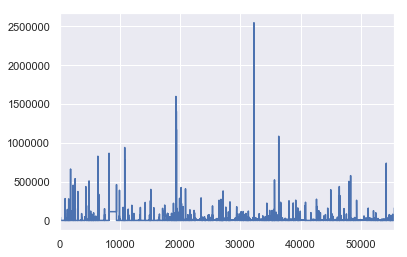

In [201]:
# below type plotting, x axis contains dump values !!!!

outliers = data

x = outliers[outliers.gross_square_feet == 0]
y = outliers[(outliers.gross_square_feet > 0) & (outliers.gross_square_feet <= 100000)]

z = outliers[(outliers.gross_square_feet > 0) & (outliers.gross_square_feet <= 20000)]

len(x), len(y), len(z), outliers.gross_square_feet.plot()

# gross_square_feet>500K seems outliers! or >20K (seems much better)

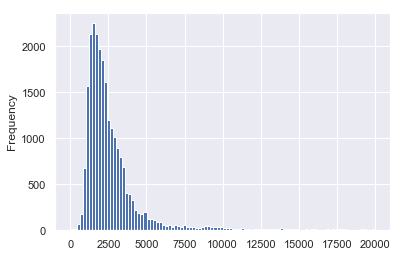

In [202]:
z.gross_square_feet.plot.hist(bins=100)

(0,
 55544,
 55353,
 51593,
 50462,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a4d709f98>)

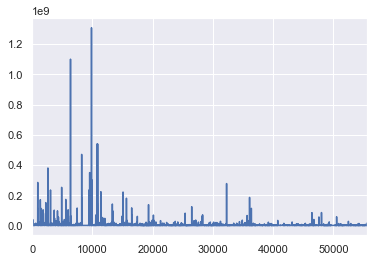

In [235]:
x = outliers[outliers.sale_price == 0]

y = outliers[outliers.sale_price <= 200000000]

z = outliers[outliers.sale_price <= 25000000]
k = outliers[outliers.sale_price <= 2500000]  # still covers most of the rows :)

m = outliers[outliers.sale_price <= 2000000]  # still covers most of the rows :)

len(x), len(y), len(z), len(k), len(m), outliers.sale_price.plot()

# data contains >0 sale_price, but it seems we also elimine under some values?

# over sale_price>2M usd seems outliers !
# or we may also create a category column depending sales_price (< 1M, ..., >200M and <500M, >500M, >900M ...)

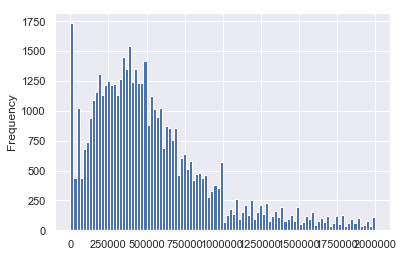

In [242]:
m.sale_price.plot.hist(bins=100)

In [245]:
data_cleaned = data_prepared

data_cleaned = data_cleaned[(data_cleaned.gross_square_feet > 0) & (data_cleaned.gross_square_feet <= 20000)]

data_cleaned = data_cleaned[(data_cleaned.sale_price < 2000000)]

len(data_cleaned)

22627

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a504cd240>,
      dtype=object)

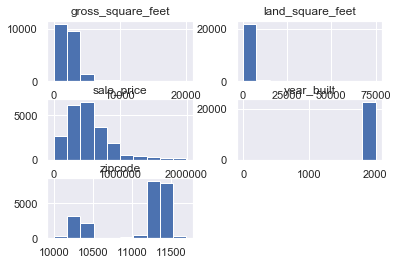

In [251]:
data_cleaned.hist()

## Enrichment etc..

- read OUTPUT data as **data_prepared** generated above

#### Problem w/ features
we have 
- so many **categorical features** which _must be mapped_ into less values, to predict sale_price and, 
- **less numerical features**, which will be used to predict sale_price

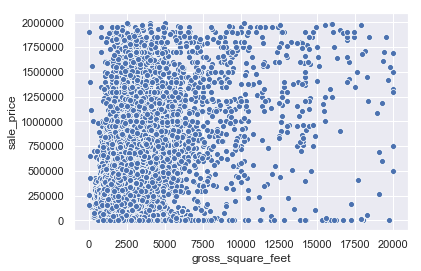

In [261]:
ax1 = sns.scatterplot(x='gross_square_feet', y='sale_price', palette='Set2', data=data_cleaned)


In [63]:
# data.gross_square_feet.plot()
kz = data[data.gross_square_feet == 0]


len(kz)

# 29K of filled sales_price rows have 0 square_feet

29311

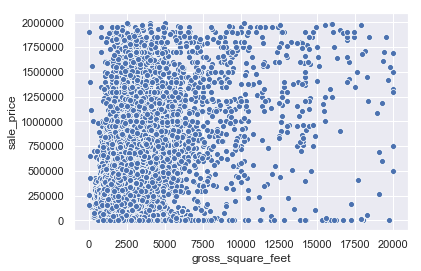

In [263]:
ax10 = sns.scatterplot(x='gross_square_feet', y='sale_price', palette='Set2', data=data_cleaned)


### Cross Analysis

In [39]:
# k = data[['building_class_name', 'residential_units']] 


# k.groupby([ 'building_class_name', 'residential_units']).size()#.sort_values(ascending=False).unstack('residential_units')#.plot(kind='pie')

In [206]:
export_csv = data_cleaned.to_csv (r'./dataset/housing/output_after_eda.csv', 
                                  index = None,
                                  header = True) 

export_csv